In [22]:
import numpy as np
import pandas as pd
import glob
from warnings import filterwarnings
filterwarnings('ignore') # Pandas'taki (normal) .mean() uyarılarını gizle

# ===============================================
# A) VERİ YÜKLEME (YENİ: .npz dosyasından)
# ===============================================

print("--- 'Premium Yakıt' (processed_data_H2H_Momentum.npz) yükleniyor... ---")

try:
    # 1. Kaydedilmiş NumPy dizilerini yükle
    data = np.load('processed_data_V2_ELO.npz', allow_pickle=True)
    
    # 2. Değişkenleri Çıkar (Extract)
    X_train = data['X_train']
    Y_train = data['Y_train']
    X_val = data['X_val']
    Y_val = data['Y_val']
    X_test = data['X_test']
    Y_test = data['Y_test']
    X_final_train = data['X_final_train']
    Y_final_train = data['Y_final_train']
    FINAL_FEATURES = data['FINAL_FEATURES'].tolist() # NumPy dizisini tekrar listeye çevir

    # 3. Ana Eğitim Değişkenlerini Ayarla
    X = X_train
    Y = Y_train
    # N_X'i YAPILANDIRMA bloğunun kullanabilmesi için burada tanımla
    N_X_loaded = X_train.shape[0] 
    
    print("--- Veri başarıyla yüklendi. ---")
    
    # 4. KONTROL (ÖZET)
    print(f"\n--- Veri Seti Özeti ---")
    print(f"Girdi Özellik Sayısı (N_X): {N_X_loaded}")
    print(f"Özellik İsimleri: {FINAL_FEATURES}")
    print("-" * 30)
    print(f"Aşama 1 (Train): {X_train.shape[1]} örnek (Değişken: X, Y)")
    print(f"Aşama 1 (Val):   {X_val.shape[1]} örnek (Değişken: X_val, Y_val)")
    print(f"Aşama 2 (Final):  {X_final_train.shape[1]} örnek (Değişken: X_final_train, Y_final_train)")
    print("-" * 30)
    print(f"Test Seti:        {X_test.shape[1]} örnek (Değişken: X_test, Y_test)")

except FileNotFoundError:
    print("\n--- HATA: 'processed_data_H2H_Momentum.npz' dosyası bulunamadı! ---")
    print("Lütfen önce 'prepare_data.py' script'ini çalıştırdığınızdan emin olun.")
    # Script'in çökmesini engellemek için sahte değişkenler oluştur
    X, Y, X_val, Y_val, X_test, Y_test, X_final_train, Y_final_train, FINAL_FEATURES, N_X_loaded = (None,)*10
except Exception as e:
    print(f"\n--- 'processed_data_H2H_Momentum.npz' yüklenirken beklenmedik bir hata oluştu: {e} ---")
    X, Y, X_val, Y_val, X_test, Y_test, X_final_train, Y_final_train, FINAL_FEATURES, N_X_loaded = (None,)*10

--- 'Premium Yakıt' (processed_data_H2H_Momentum.npz) yükleniyor... ---
--- Veri başarıyla yüklendi. ---

--- Veri Seti Özeti ---
Girdi Özellik Sayısı (N_X): 31
Özellik İsimleri: ['p1_age', 'p1_ht', 'p1_rank', 'p1_is_L', 'p1_rank_diff', 'p2_age', 'p2_ht', 'p2_rank', 'p2_is_L', 'p1_elo_pre_match', 'p2_elo_pre_match', 'p1_elo_diff', 'p1_career_win_rate', 'p1_surface_win_rate', 'p1_momentum_win', 'p1_h2h_rate', 'p1_career_ace_rate', 'p1_momentum_ace', 'p1_fatigue_7d_mins', 'p2_career_win_rate', 'p2_surface_win_rate', 'p2_momentum_win', 'p2_h2h_rate', 'p2_career_ace_rate', 'p2_momentum_ace', 'p2_fatigue_7d_mins', 'h2h_matches_played', 'surface_Clay', 'surface_Grass', 'surface_Hard', 'surface_nan']
------------------------------
Aşama 1 (Train): 188934 örnek (Değişken: X, Y)
Aşama 1 (Val):   2986 örnek (Değişken: X_val, Y_val)
Aşama 2 (Final):  191920 örnek (Değişken: X_final_train, Y_final_train)
------------------------------
Test Seti:        3076 örnek (Değişken: X_test, Y_test)


In [23]:
# ===============================================
# YAPILANDIRMA: HİPER-PARAMETRELER (YENİ YAKIT İÇİN GÜÇLENDİRİLDİ)
# ===============================================
N_X = N_X_loaded        # Girdi Boyutu (Artık ~31 özellik)

# YENİ: Motoru büyüt (Kapasiteyi artır)
N_H1 = 128              # 64'ten 128'e çıkarıldı
N_H2 = 64               # 32'den 64'e çıkarıldı
N_Y = Y.shape[0]        # Çıktı Boyutu (1)

# YENİ: Daha büyük bir motor için daha "güvenli" ayarlar
LEARNING_RATE = 0.01    # 0.05'ten 0.01'e düşürüldü (Daha stabil öğrenme için)
EPOCHS = 5000           
PATIENCE = 7            

# --- ADAM OPTIMIZER PARAMETRELERİ ---
BETA1 = 0.9     
BETA2 = 0.999   
EPSILON = 1e-8  

# YENİ: Daha güçlü bir motor, daha güçlü bir ceza (Overfitting'i önle)
LAMBDA = 0.5            # 0.1'den 0.5'e çıkarıldı (Daha güçlü düzenlileştirme)

# GÜNCELLENMİŞ KONTROL ÇIKTISI
print(f"--- Mimari Ayarlanıyor (Premium Yakıt) ---")
print(f"Girdi Boyutu (N_X): {N_X}")
print(f"Gizli Katman 1 (N_H1): {N_H1}")
print(f"Gizli Katman 2 (N_H2): {N_H2}")
print(f"Öğrenme Hızı: {LEARNING_RATE} | L2 Ceza (Lambda): {LAMBDA}")

--- Mimari Ayarlanıyor (Premium Yakıt) ---
Girdi Boyutu (N_X): 31
Gizli Katman 1 (N_H1): 128
Gizli Katman 2 (N_H2): 64
Öğrenme Hızı: 0.01 | L2 Ceza (Lambda): 0.5


In [24]:
# ===============================================
# A) YARDIMCI FONKSİYONLAR (HELPER FUNCTIONS)
# ===============================================

def sigmoid(Z):
    """Sigmoid aktivasyon fonksiyonunu hesaplar. Çıktıyı 0 ile 1 arasına sıkıştırır."""
    A = 1 / (1 + np.exp(-Z))
    return A

# (sigmoid_backward fonksiyonuna artık ihtiyacımız yok,
# geriye yayılım fonksiyonları kendi türevlerini içeriyor)

# ===============================================
# B) MODEL SINIFI VE BAŞLATMA (2 GİZLİ KATMAN)
# ===============================================

# --- Model 1: Tanh / Xavier (2 Katmanlı) ---

def initialize_parameters_Xavier(n_x, n_h1, n_h2, n_y):
    """ 2 Gizli Katmanlı (H1, H2) ağ için Xavier başlatması yapar. """
    W1 = np.random.randn(n_h1, n_x) * np.sqrt(1 / n_x)
    b1 = np.zeros((n_h1, 1))
    W2 = np.random.randn(n_h2, n_h1) * np.sqrt(1 / n_h1) # H1 -> H2
    b2 = np.zeros((n_h2, 1))
    W3 = np.random.randn(n_y, n_h2) * np.sqrt(1 / n_h2) # H2 -> Çıktı
    b3 = np.zeros((n_y, 1))
    
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}
    return parameters

def forward_propagation_tanh(X, parameters):
    """ 2 Gizli Katmanlı (tanh, tanh) ağ için ileri yayılım. """
    W1, b1 = parameters["W1"], parameters["b1"]
    W2, b2 = parameters["W2"], parameters["b2"]
    W3, b3 = parameters["W3"], parameters["b3"]
    
    # Katman 1 (Girdi -> H1)
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1) 
    # Katman 2 (H1 -> H2)
    Z2 = np.dot(W2, A1) + b2
    A2 = np.tanh(Z2) 
    # Katman 3 (H2 -> Çıktı)
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3) # Nihai tahmin
    
    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2, "Z3": Z3, "A3": A3}
    return A3, cache # Nihai tahmin A3'tür

# --- Model 2: Leaky ReLU / He (2 Katmanlı) ---

def initialize_parameters_He(n_x, n_h1, n_h2, n_y):
    """ 2 Gizli Katmanlı (H1, H2) ağ için He başlatması yapar. """
    W1 = np.random.randn(n_h1, n_x) * np.sqrt(2 / n_x)
    b1 = np.zeros((n_h1, 1))
    W2 = np.random.randn(n_h2, n_h1) * np.sqrt(2 / n_h1) # H1 -> H2
    b2 = np.zeros((n_h2, 1))
    W3 = np.random.randn(n_y, n_h2) * np.sqrt(2 / n_h2) # H2 -> Çıktı
    b3 = np.zeros((n_y, 1))
    
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}
    return parameters

def forward_propagation_LeakyReLU(X, parameters):
    """ 2 Gizli Katmanlı (LReLU, LReLU) ağ için ileri yayılım. """
    W1, b1 = parameters["W1"], parameters["b1"]
    W2, b2 = parameters["W2"], parameters["b2"]
    W3, b3 = parameters["W3"], parameters["b3"]
    
    # Katman 1 (Girdi -> H1)
    Z1 = np.dot(W1, X) + b1
    A1 = np.maximum(0.01 * Z1, Z1) # LReLU
    # Katman 2 (H1 -> H2)
    Z2 = np.dot(W2, A1) + b2
    A2 = np.maximum(0.01 * Z2, Z2) # LReLU
    # Katman 3 (H2 -> Çıktı)
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3) # Nihai tahmin
    
    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2, "Z3": Z3, "A3": A3}
    return A3, cache # Nihai tahmin A3'tür

# ===============================================
# D) MALİYET FONKSİYONU (JENERİK L2 GÜNCELLENMESİ)
# ===============================================

def compute_cost(A_out, Y, parameters, lambd=0): 
    """
    İkili Çapraz Entropi ve (Jenerik) L2 Düzenlileştirme cezasını hesaplar.
    A_out: Ağın nihai aktivasyonu (A2, A3, vb.)
    """
    m = Y.shape[1] 
    
    # 1. Çapraz Entropi Maliyeti
    epsilon = 1e-8 
    A_clipped = np.clip(A_out, epsilon, 1 - epsilon)
    log_probs = Y * np.log(A_clipped)
    log_probs_complement = (1 - Y) * np.log(1 - A_clipped)
    cross_entropy_cost = - (1 / m) * (np.sum(log_probs + log_probs_complement))
    
    # 2. L2 Düzenlileştirme Cezası (YENİ: Jenerik)
    # parameters sözlüğündeki (W1, W2, W3...) tüm ağırlıklar için
    L2_cost = 0
    L = len(parameters) // 2 # Katman sayısı (W,b çiftleri)
    for l in range(1, L + 1):
        L2_cost += np.sum(np.square(parameters["W" + str(l)]))
        
    L2_regularization_cost = (lambd / (2 * m)) * L2_cost
    
    cost = cross_entropy_cost + L2_regularization_cost
    cost = np.squeeze(cost) 
    
    return cost

# ===============================================
# E) GERİYE YAYILIM (BACKWARD PROPAGATION) (2 KATMAN İÇİN)
# ===============================================

def backward_propagation_tanh(parameters, cache, X, Y, lambd=0):
    """ 2 Katmanlı tanh ağı için L2 uyumlu geriye yayılım. """
    m = X.shape[1]
    # Cache'den 2. katman aktivasyonlarını da al
    A1, A2, A3 = cache["A1"], cache["A2"], cache["A3"]
    W1, W2, W3 = parameters["W1"], parameters["W2"], parameters["W3"]
    
    # Katman 3 (Çıktı)
    dZ3 = A3 - Y
    dW3 = (1 / m) * np.dot(dZ3, A2.T) + (lambd / m) * W3
    db3 = np.mean(dZ3, axis=1, keepdims=True)
    
    # Katman 2 (Gizli)
    dZ2_weighted = np.dot(W3.T, dZ3)
    dZ2 = dZ2_weighted * (1 - np.power(A2, 2)) # tanh türevi (A2 kullanılır)
    dW2 = (1 / m) * np.dot(dZ2, A1.T) + (lambd / m) * W2
    db2 = np.mean(dZ2, axis=1, keepdims=True)
    
    # Katman 1 (Gizli)
    dZ1_weighted = np.dot(W2.T, dZ2)
    dZ1 = dZ1_weighted * (1 - np.power(A1, 2)) # tanh türevi (A1 kullanılır)
    dW1 = (1 / m) * np.dot(dZ1, X.T) + (lambd / m) * W1
    db1 = np.mean(dZ1, axis=1, keepdims=True)
    
    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2, "dW3": dW3, "db3": db3}
    return grads

def backward_propagation_LeakyReLU(parameters, cache, X, Y, lambd=0):
    """ 2 Katmanlı Leaky ReLU ağı için L2 uyumlu geriye yayılım. """
    m = X.shape[1]
    A1, A2, A3 = cache["A1"], cache["A2"], cache["A3"]
    W1, W2, W3 = parameters["W1"], parameters["W2"], parameters["W3"]
    
    # Katman 3 (Çıktı)
    dZ3 = A3 - Y
    dW3 = (1 / m) * np.dot(dZ3, A2.T) + (lambd / m) * W3
    db3 = np.mean(dZ3, axis=1, keepdims=True)
    
    # Katman 2 (Gizli)
    dZ2_weighted = np.dot(W3.T, dZ3)
    dZ2_act = np.where(A2 > 0, 1.0, 0.01) # LReLU türevi (A2 kullanılır)
    dZ2 = dZ2_weighted * dZ2_act
    dW2 = (1 / m) * np.dot(dZ2, A1.T) + (lambd / m) * W2
    db2 = np.mean(dZ2, axis=1, keepdims=True)
    
    # Katman 1 (Gizli)
    dZ1_weighted = np.dot(W2.T, dZ2)
    dZ1_act = np.where(A1 > 0, 1.0, 0.01) # LReLU türevi (A1 kullanılır)
    dZ1 = dZ1_weighted * dZ1_act
    dW1 = (1 / m) * np.dot(dZ1, X.T) + (lambd / m) * W1
    db1 = np.mean(dZ1, axis=1, keepdims=True)
    
    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2, "dW3": dW3, "db3": db3}
    return grads

# ===============================================
# F) PARAMETRE GÜNCELLEME (JENERİK HALE GETİRİLDİ)
# ===============================================

def update_parameters_gradient_descent(parameters, grads, learning_rate):
    """ Jenerik (L katmanlı) ağ için basit Gradyan İnişi. """
    L = len(parameters) // 2 # Katman sayısı (2 veya 3 olacak)
    
    for l in range(1, L + 1):
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)]
        
    return parameters

# --- Adam Optimizasyonu Fonksiyonları (DEĞİŞİKLİK GEREKMEZ) ---
# Bu fonksiyonlar zaten jenerik (L katmanlı) yazılmıştı.
# L=3 (W1,W2,W3) için sorunsuz çalışacaklar.

def initialize_adam(parameters):
    v = {}
    s = {}
    L = len(parameters) // 2 
    for l in range(1, L + 1):
        v["dW" + str(l)] = np.zeros(parameters["W" + str(l)].shape)
        v["db" + str(l)] = np.zeros(parameters["b" + str(l)].shape)
        s["dW" + str(l)] = np.zeros(parameters["W" + str(l)].shape)
        s["db" + str(l)] = np.zeros(parameters["b" + str(l)].shape)
    return v, s

def update_parameters_adam(parameters, grads, v, s, t, learning_rate, beta1, beta2, epsilon):
    L = len(parameters) // 2 
    v_corrected = {} 
    s_corrected = {} 
    
    for l in range(1, L + 1):
        dW = grads["dW" + str(l)]
        db = grads["db" + str(l)]
        
        # v ve s'yi güncelle
        v["dW" + str(l)] = beta1 * v["dW" + str(l)] + (1 - beta1) * dW
        v["db" + str(l)] = beta1 * v["db" + str(l)] + (1 - beta1) * db
        s["dW" + str(l)] = beta2 * s["dW" + str(l)] + (1 - beta2) * np.power(dW, 2)
        s["db" + str(l)] = beta2 * s["db" + str(l)] + (1 - beta2) * np.power(db, 2)
        
        # Bias düzeltmesi
        v_corrected["dW" + str(l)] = v["dW" + str(l)] / (1 - np.power(beta1, t))
        v_corrected["db" + str(l)] = v["db" + str(l)] / (1 - np.power(beta1, t))
        s_corrected["dW" + str(l)] = s["dW" + str(l)] / (1 - np.power(beta2, t))
        s_corrected["db" + str(l)] = s["db" + str(l)] / (1 - np.power(beta2, t))
        
        # Parametre güncelleme
        W_update = (learning_rate * v_corrected["dW" + str(l)]) / (np.sqrt(s_corrected["dW" + str(l)]) + epsilon)
        b_update = (learning_rate * v_corrected["db" + str(l)]) / (np.sqrt(s_corrected["db" + str(l)]) + epsilon)
        
        parameters["W" + str(l)] = parameters["W" + str(l)] - W_update
        parameters["b" + str(l)] = parameters["b" + str(l)] - b_update

    return parameters, v, s

# ===============================================
# G) ANA EĞİTİM FONKSİYONLARI (2 KATMAN İÇİN GÜNCELLENDİ)
# ===============================================

# --- Model 1: Tanh / Xavier (2 Katmanlı) ---
def train_ann_tanh_xavier(X, Y, n_h1, n_h2, learning_rate, num_epochs, # n_h -> n_h1, n_h2
              X_val=None, Y_val=None, 
              print_cost=False, patience=3,
              lambd=0): # L2 eklendi
    
    n_x, n_y = X.shape[0], Y.shape[0] 
    
    # 2 Katmanlı başlatmayı çağır
    parameters = initialize_parameters_Xavier(n_x, n_h1, n_h2, n_y)
    
    costs, validation_costs = [], []
    best_val_cost, patience_counter, best_epoch = np.inf, 0, 0
    best_parameters = {}
    
    do_validation = X_val is not None and Y_val is not None
    print_interval = num_epochs / 100 if (num_epochs / 100) >= 1 else 1
    
    if not do_validation:
        patience = np.inf 
        if print_cost:
            print("--- UYARI: Validation seti yok. Erken Durdurma devre dışı. ---")

    for i in range(num_epochs):
        
        # 2 Katmanlı fonksiyonları çağır
        A_out, cache = forward_propagation_tanh(X, parameters)
        cost = compute_cost(A_out, Y, parameters, lambd) # A_out = A3
        grads = backward_propagation_tanh(parameters, cache, X, Y, lambd)
        parameters = update_parameters_gradient_descent(parameters, grads, learning_rate)
        
        if i % print_interval == 0:
            costs.append(cost) 
            
            if do_validation:
                A_val, _ = forward_propagation_tanh(X_val, parameters) 
                cost_val = compute_cost(A_val, Y_val, parameters, lambd) 
                validation_costs.append(cost_val) 
                
                if print_cost:
                    print(f"Epoch {i} | EĞİTİM Maliyeti: {cost:.4f} | DOĞRULAMA Maliyeti: {cost_val:.4f}")
                
                if cost_val < best_val_cost:
                    best_val_cost, best_parameters, best_epoch, patience_counter = cost_val, parameters.copy(), i, 0
                    if print_cost: print(f"          -> (Yeni en iyi model kaydedildi.)")
                else:
                    patience_counter += 1
                    if print_cost: print(f"          -> (Sabır: {patience_counter}/{patience})")
                
                if patience_counter >= patience:
                    print(f"\n--- ERKEN DURDURMA: {best_epoch} epoch'ta durduruldu. (Maliyet: {best_val_cost:.4f})")
                    break 
            else:
                validation_costs.append(np.nan) 
                if print_cost: print(f"Epoch {i} | EĞİTİM Maliyeti: {cost:.4f}")
            
    if do_validation and best_parameters:
        return best_parameters, costs, validation_costs
    
    return parameters, costs, validation_costs

# --- Model 2: Leaky ReLU / He / Adam (2 Katmanlı) ---
def train_ann_LeakyReLU_He(X, Y, n_h1, n_h2, learning_rate, num_epochs, # n_h -> n_h1, n_h2
              X_val=None, Y_val=None, 
              print_cost=False, patience=3,
              beta1=BETA1, beta2=BETA2, epsilon=EPSILON,
              lambd=0): 
    
    n_x, n_y = X.shape[0], Y.shape[0] 
    
    # 2 Katmanlı başlatmayı çağır
    parameters = initialize_parameters_He(n_x, n_h1, n_h2, n_y)
    v, s = initialize_adam(parameters) # Adam (L=3 için çalışır)
    t = 0 
    
    costs, validation_costs = [], []
    best_val_cost, patience_counter, best_epoch = np.inf, 0, 0
    best_parameters = {}
    
    do_validation = X_val is not None and Y_val is not None
    print_interval = num_epochs / 100 if (num_epochs / 100) >= 1 else 1
    
    if not do_validation:
        patience = np.inf 
        if print_cost:
            print("--- UYARI: Validation seti yok. Erken Durdurma devre dışı. ---")

    for i in range(num_epochs):
        
        # 2 Katmanlı fonksiyonları çağır
        A_out, cache = forward_propagation_LeakyReLU(X, parameters)
        cost = compute_cost(A_out, Y, parameters, lambd) # A_out = A3
        grads = backward_propagation_LeakyReLU(parameters, cache, X, Y, lambd)
        t += 1
        parameters, v, s = update_parameters_adam(parameters, grads, v, s, t, 
                                             learning_rate, beta1, beta2, epsilon)
        
        if i % print_interval == 0:
            costs.append(cost) 
            
            if do_validation:
                A_val, _ = forward_propagation_LeakyReLU(X_val, parameters) 
                cost_val = compute_cost(A_val, Y_val, parameters, lambd) 
                validation_costs.append(cost_val) 
                
                if print_cost:
                    print(f"Epoch {i} | EĞİTİM Maliyeti: {cost:.4f} | DOĞRULAMA Maliyeti: {cost_val:.4f}")
                
                if cost_val < best_val_cost:
                    best_val_cost, best_parameters, best_epoch, patience_counter = cost_val, parameters.copy(), i, 0
                    if print_cost: print(f"          -> (Yeni en iyi model kaydedildi.)")
                else:
                    patience_counter += 1
                    if print_cost: print(f"          -> (Sabır: {patience_counter}/{patience})")
                
                if patience_counter >= patience:
                    print(f"\n--- ERKEN DURDURMA: {best_epoch} epoch'ta durduruldu. (Maliyet: {best_val_cost:.4f})")
                    break 
            else:
                validation_costs.append(np.nan) 
                if print_cost: print(f"Epoch {i} | EĞİTİM Maliyeti: {cost:.4f}")
            
    if do_validation and best_parameters:
        return best_parameters, costs, validation_costs
    
    return parameters, costs, validation_costs

In [25]:
# ===============================================
# H) ANA KONTROL VE EĞİTİM BLOKU (2 KATMAN İÇİN GÜNCELLENDİ)
# ===============================================

print(f"\n--- Model Eğitimi Başlatılıyor ---")
# GÜNCELLENDİ: N_H -> N_H1, N_H2
print(f"Girdi Boyutu (N_X): {N_X} | Katman 1 (N_H1): {N_H1} | Katman 2 (N_H2): {N_H2}") 
print(f"Öğrenme Hızı: {LEARNING_RATE} | Sabır: {PATIENCE} | L2 Ceza (Lambda): {LAMBDA}")
print("-" * 30)

# Kullanıcıya ne yapmak istediğini sor
print("Hangi modu çalıştırmak istersiniz?")
print("  1: Aşama 1 - En iyi epoch'u bul (Validation ve Erken Durdurma Aktif)")
print("  2: Aşama 2 - Nihai modeli eğit (Validation Kapalı, Tüm Veri Kullanılır)")
print("-" * 30)
user_choice = input("Lütfen seçiminizi yapın (1 veya 2): ")

# Kullanıcıya hangi yöntem ile çalıştırmak istediğini sor
print("Hangi modeli çalıştırmak istersiniz?")
print(" 1 - Xavier başlatması ile aktivasyon fonksiyonu olarak Tanh mi? (Yavaş)")
print(" 2 - He başlatması ile aktivasyon fonksiyonu olarak Leaky ReLU mu? (Hızlı - Önerilir)")
print("-" * 30)
model_choice = input("Lütfen seçiminizi yapın (1 veya 2): ")

# --- Değişkenleri varsayılan olarak tanımla ---
optimized_parameters = {}
costs = []
validation_costs = []
plot_title = ""

if user_choice == '1':
    # --- AŞAMA 1: VALIDATION (ERKEN DURDURMA) İLE EĞİTİM ---
    print("\n--- AŞAMA 1 BAŞLATILIYOR: En İyi Epoch Bulunacak ---")
    
    if model_choice == '1':
        print("\n--- Tanh ile Xavier kullanılarak validation ile eğitim başlıyor ---")
        optimized_parameters, costs, validation_costs = train_ann_tanh_xavier( 
            X=X,  # 1968-2021
            Y=Y,  # 1968-2021
            n_h1=N_H1, n_h2=N_H2, # GÜNCELLENDİ
            learning_rate=LEARNING_RATE, 
            num_epochs=EPOCHS, 
            X_val=X_val,  # 2022-2023 (Aktif)
            Y_val=Y_val,  # 2022-2023 (Aktif)
            print_cost=True,
            patience=PATIENCE,
            lambd=LAMBDA # GÜNCELLENDİ (Tutarlılık için)
        )
        
    elif model_choice == '2':
        print("\n--- Leaky ReLU ile He kullanılarak validation ile eğitim başlıyor ---")
        optimized_parameters, costs, validation_costs = train_ann_LeakyReLU_He( 
            X=X,  # 1968-2021
            Y=Y,  # 1968-2021
            n_h1=N_H1, n_h2=N_H2, # GÜNCELLENDİ
            learning_rate=LEARNING_RATE, 
            num_epochs=EPOCHS, 
            X_val=X_val,  # 2022-2023 (Aktif)
            Y_val=Y_val,  # 2022-2023 (Aktif)
            print_cost=True,
            patience=PATIENCE,
            lambd=LAMBDA
        )

    plot_title = f"Aşama 1: Maliyet (LR: {LEARNING_RATE}, H1: {N_H1}, H2: {N_H2})" # GÜNCELLENDİ
    print(f"\n--- AŞAMA 1 TAMAMLANDI. Lütfen grafiği ve 'En iyi epoch' sayısını not edin. ---")

elif user_choice == '2':
    # --- AŞAMA 2: NİHAİ MODEL EĞİTİMİ ---
    print("\n--- AŞAMA 2 BAŞLATILIYOR: Nihai Model Eğitilecek ---")
    
    # Kullanıcıdan, Aşama 1'de bulduğu 'en iyi epoch' sayısını iste
    try:
        best_epoch_str = input(f"Aşama 1'de bulduğunuz 'en iyi' epoch sayısını girin (örn: 1350): ")
        FINAL_EPOCHS = int(best_epoch_str)
        if FINAL_EPOCHS <= 0: raise ValueError
    except ValueError:
        print(f"Geçersiz sayı. Varsayılan olarak {EPOCHS} epoch kullanılacak.")
        FINAL_EPOCHS = EPOCHS

    if model_choice == '1':
        print("\n--- Tanh ile Xavier kullanılarak validation olmadan eğitim başlıyor ---")
        optimized_parameters, costs, validation_costs = train_ann_tanh_xavier( 
            X=X_final_train,  # 1968-2023 (Birleşik)
            Y=Y_final_train,  # 1968-2023 (Birleşik)
            n_h1=N_H1, n_h2=N_H2, # GÜNCELLENDİ
            learning_rate=LEARNING_RATE, 
            num_epochs=FINAL_EPOCHS, # Sadece 'en iyi' bulunan epoch kadar
            X_val=None,  # <-- DEVRE DIŞI
            Y_val=None,  # <-- DEVRE DIŞI
            print_cost=True,
            patience=9999, # (Etkisiz)
            lambd=LAMBDA # GÜNCELLENDİ (Tutarlılık için)
        )
        
    elif model_choice == '2':
        print("\n--- Leaky ReLU ile He kullanılarak validation olmadan eğitim başlıyor ---")
        optimized_parameters, costs, validation_costs = train_ann_LeakyReLU_He( 
            X=X_final_train,  # 1968-2023 (Birleşik)
            Y=Y_final_train,  # 1968-2023 (Birleşik)
            n_h1=N_H1, n_h2=N_H2, # GÜNCELLENDİ
            learning_rate=LEARNING_RATE, 
            num_epochs=FINAL_EPOCHS, 
            X_val=None,  # <-- DEVRE DIŞI
            Y_val=None,  # <-- DEVRE DIŞI
            print_cost=True,
            patience=9999,
            lambd=LAMBDA
        )
    
    plot_title = f"Aşama 2: Maliyet (LR: {LEARNING_RATE}, H1: {N_H1}, H2: {N_H2})" # GÜNCELLENDİ
    print(f"\n--- AŞAMA 2 (NİHAİ EĞİTİM) TAMAMLANDI. ---")
    
else:
    print("Geçersiz seçim. Program durduruluyor.")
    # (Program durur, 'optimized_parameters' boş kalır)


--- Model Eğitimi Başlatılıyor ---
Girdi Boyutu (N_X): 31 | Katman 1 (N_H1): 128 | Katman 2 (N_H2): 64
Öğrenme Hızı: 0.01 | Sabır: 7 | L2 Ceza (Lambda): 0.5
------------------------------
Hangi modu çalıştırmak istersiniz?
  1: Aşama 1 - En iyi epoch'u bul (Validation ve Erken Durdurma Aktif)
  2: Aşama 2 - Nihai modeli eğit (Validation Kapalı, Tüm Veri Kullanılır)
------------------------------
Hangi modeli çalıştırmak istersiniz?
 1 - Xavier başlatması ile aktivasyon fonksiyonu olarak Tanh mi? (Yavaş)
 2 - He başlatması ile aktivasyon fonksiyonu olarak Leaky ReLU mu? (Hızlı - Önerilir)
------------------------------

--- AŞAMA 1 BAŞLATILIYOR: En İyi Epoch Bulunacak ---

--- Leaky ReLU ile He kullanılarak validation ile eğitim başlıyor ---
Epoch 0 | EĞİTİM Maliyeti: 0.8982 | DOĞRULAMA Maliyeti: 1.1430
          -> (Yeni en iyi model kaydedildi.)
Epoch 50 | EĞİTİM Maliyeti: 0.5962 | DOĞRULAMA Maliyeti: 0.6692
          -> (Yeni en iyi model kaydedildi.)
Epoch 100 | EĞİTİM Maliyeti: 0.

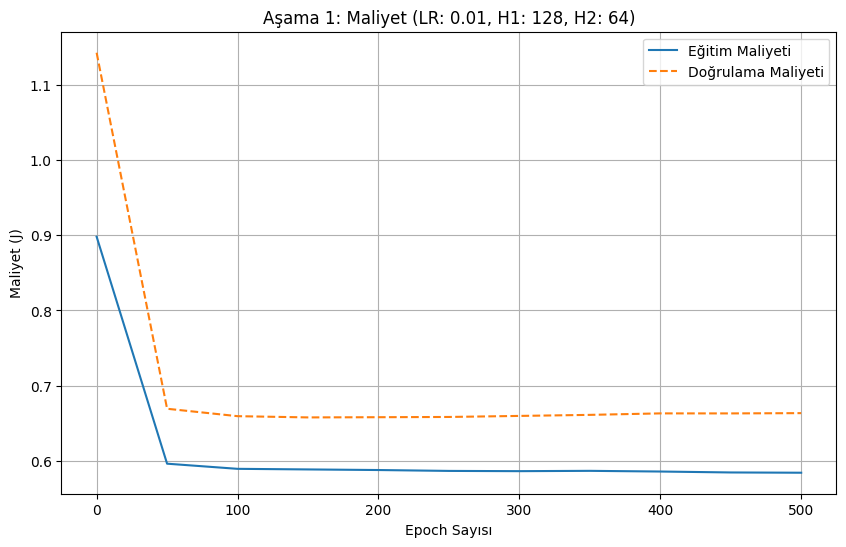

In [26]:
# ===============================================
# I) GÖRSELLEŞTİRME VE NİHAİ PERFORMANS
# ===============================================

# 1. GÖRSELLEŞTİRME
# (Eğer bir eğitim yapıldıysa grafiği çiz)
if optimized_parameters:
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))

    # X eksenini 'costs' listesinin gerçek uzunluğuna göre dinamik olarak oluştur
    print_interval = EPOCHS / 100 if (EPOCHS / 100) >= 1 else 1
    # 'costs' listesinin (erken durmuş olabilir) gerçek uzunluğunu al
    num_points_in_plot = len(costs) 
    epochs_list_actual = np.arange(0, num_points_in_plot) * print_interval

    # Eğitim Maliyeti
    plt.plot(epochs_list_actual, costs, label="Eğitim Maliyeti")
    
    # Doğrulama Maliyeti (Sadece Aşama 1'de çizilir)
    # (Aşama 2'de 'validation_costs' listesi NaN dolu olacağı için)
    plt.plot(epochs_list_actual, validation_costs, label="Doğrulama Maliyeti", linestyle='--')

    plt.title(plot_title)
    plt.xlabel("Epoch Sayısı")
    plt.ylabel("Maliyet (J)")
    plt.legend()
    plt.grid(True)
    plt.show()


In [27]:
# J) DOĞRULUK HESAPLAMA FONKSİYONU
def evaluate_accuracy(Y_prediction, Y_true):
    """
    Tahminleri (Y_prediction) gerçek etiketlerle (Y_true) karşılaştırarak
    modelin doğruluk skorunu hesaplar.
    """
    # NumPy'da iki matrisi karşılaştırmak için == kullanılır. 
    # Sonuç (True=1, False=0) matrisidir.
    correct_predictions = (Y_prediction == Y_true)
    
    # Ortalama almak, bize doğrudan doğru tahminlerin oranını (Doğruluğu) verir.
    accuracy = np.mean(correct_predictions) 
    
    return accuracy


# I) TAHMİN FONKSİYONU
def predict(parameters, X, model_choice):
    """
    Eğitilmiş parametreleri kullanarak girdi X için tahmin yapar.
    
    Argümanlar:
    parameters -- Eğitilmiş W ve b parametreleri sözlüğü
    X -- Tahmin edilecek girdi matrisi (N, m)
    
    Döndürür:
    Y_prediction -- Girdi X için 0 veya 1 etiketlerinden oluşan NumPy vektörü
    """
    
    if model_choice == '1':
        A2, cache = forward_propagation_tanh(X, parameters)
    elif model_choice == '2':
        A2, cache = forward_propagation_LeakyReLU(X, parameters)    
    
    # Karar Eşiği (Threshold): Olasılık 0.5'ten büyükse 1 (kazandı), değilse 0 (kaybetti).
    Y_prediction = (A2 > 0.5).astype(int)
    
    return Y_prediction

In [28]:
# K) NİHAİ PERFORMANS VE SONUÇ BLOĞU

# 1. Test Seti Tahmini (2024 verisi)
# optimized_parameters: train_ann'den gelen eğitilmiş W ve b değerleri
Y_pred_test = predict(optimized_parameters, X_test, model_choice)

# 2. Doğruluk Hesaplama
# Modelin 2024 verisindeki nihai performansı
test_accuracy = evaluate_accuracy(Y_pred_test, Y_test)

print(f"\n--- Model Değerlendirmesi ---")
print(f"Eğitim Seti (1968-2021) Örnek Sayısı: {X.shape[1]}")
print(f"Doğrulama Seti (2022-2023) Örnek Sayısı: {X_val.shape[1]}")
print(f"Test Seti (2024) Örnek Sayısı: {X_test.shape[1]}")
print("-" * 35)
print(f"Nihai TEST Doğruluğu (2024): {test_accuracy*100:.2f}%")
print("-" * 35)


--- Model Değerlendirmesi ---
Eğitim Seti (1968-2021) Örnek Sayısı: 188934
Doğrulama Seti (2022-2023) Örnek Sayısı: 2986
Test Seti (2024) Örnek Sayısı: 3076
-----------------------------------
Nihai TEST Doğruluğu (2024): 64.04%
-----------------------------------
